# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

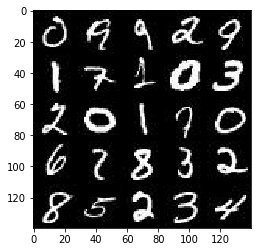

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

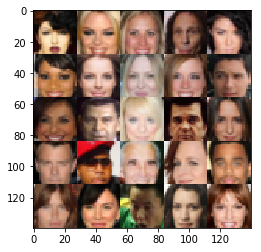

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64 now
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256 now

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, [-1, 7, 7, 512])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='SAME')
        # 28x28x3
        
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
class DCGAN:
    def __init__(self, image_width=28, image_height=28, image_channels=1, z_dim=100, out_channel_dim=1, beta1=0.5):
        #tf.reset_default_graph()
        
        # placeholder
        self.input_real, self.input_z, self.learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
        
        # loss
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, out_channel_dim)
        
        # optimizer
        self.d_train_opt, self.g_train_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    net = DCGAN(image_width=data_shape[1], image_height=data_shape[2], image_channels=data_shape[3],
               z_dim=z_dim, out_channel_dim=data_shape[3], beta1=beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps = steps + 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(net.d_train_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate: learning_rate})
                _ = sess.run(net.g_train_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 16, net.input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 0.8196
Epoch 1/2... Discriminator Loss: 1.5330... Generator Loss: 2.4600
Epoch 1/2... Discriminator Loss: 3.3720... Generator Loss: 0.0872
Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 1.1439
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 0.9345
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 1.3250
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 1.8306
Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 1.4349
Epoch 1/2... Discriminator Loss: 0.7594... Generator Loss: 1.9894
Epoch 1/2... Discriminator Loss: 1.1408... Generator Loss: 0.6712


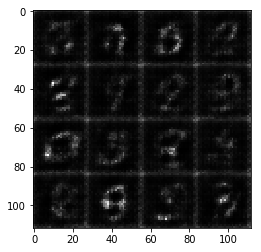

Epoch 1/2... Discriminator Loss: 0.5909... Generator Loss: 1.6830
Epoch 1/2... Discriminator Loss: 0.7255... Generator Loss: 3.9556
Epoch 1/2... Discriminator Loss: 0.4581... Generator Loss: 2.4388
Epoch 1/2... Discriminator Loss: 0.4017... Generator Loss: 3.0076
Epoch 1/2... Discriminator Loss: 0.4257... Generator Loss: 2.9201
Epoch 1/2... Discriminator Loss: 0.4176... Generator Loss: 2.7391
Epoch 1/2... Discriminator Loss: 0.3598... Generator Loss: 4.1649
Epoch 1/2... Discriminator Loss: 0.3751... Generator Loss: 4.1962
Epoch 1/2... Discriminator Loss: 0.3538... Generator Loss: 4.5244
Epoch 1/2... Discriminator Loss: 0.3721... Generator Loss: 3.7702


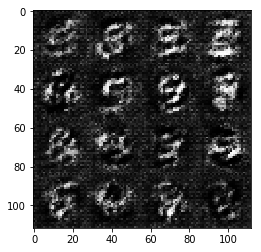

Epoch 1/2... Discriminator Loss: 0.4277... Generator Loss: 4.2682
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 5.3397
Epoch 1/2... Discriminator Loss: 0.4080... Generator Loss: 3.1314
Epoch 2/2... Discriminator Loss: 0.3423... Generator Loss: 7.2374
Epoch 2/2... Discriminator Loss: 0.3794... Generator Loss: 3.3627
Epoch 2/2... Discriminator Loss: 0.3590... Generator Loss: 4.4752
Epoch 2/2... Discriminator Loss: 0.7633... Generator Loss: 2.5416
Epoch 2/2... Discriminator Loss: 0.3868... Generator Loss: 3.5416
Epoch 2/2... Discriminator Loss: 0.3567... Generator Loss: 6.7930
Epoch 2/2... Discriminator Loss: 0.9503... Generator Loss: 1.5540


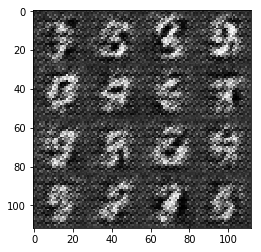

Epoch 2/2... Discriminator Loss: 0.8672... Generator Loss: 1.6918
Epoch 2/2... Discriminator Loss: 0.7996... Generator Loss: 1.6309
Epoch 2/2... Discriminator Loss: 1.9226... Generator Loss: 0.2932
Epoch 2/2... Discriminator Loss: 0.4911... Generator Loss: 2.2728
Epoch 2/2... Discriminator Loss: 0.5603... Generator Loss: 1.7821
Epoch 2/2... Discriminator Loss: 0.8474... Generator Loss: 1.6226
Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 2.0729
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 0.7691
Epoch 2/2... Discriminator Loss: 0.3386... Generator Loss: 7.0575
Epoch 2/2... Discriminator Loss: 0.3449... Generator Loss: 5.4749


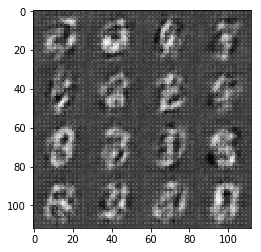

Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 4.7464
Epoch 2/2... Discriminator Loss: 0.4913... Generator Loss: 2.1731
Epoch 2/2... Discriminator Loss: 0.4584... Generator Loss: 2.4072
Epoch 2/2... Discriminator Loss: 1.1170... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 0.4364... Generator Loss: 3.0326
Epoch 2/2... Discriminator Loss: 0.4388... Generator Loss: 2.6098


In [13]:
batch_size = 256
z_dim = 512
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.2389
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 2.2061
Epoch 1/1... Discriminator Loss: 0.4203... Generator Loss: 4.1627
Epoch 1/1... Discriminator Loss: 0.4925... Generator Loss: 2.6502
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 5.6820


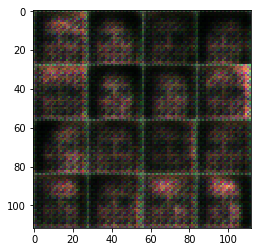

Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 2.0360
Epoch 1/1... Discriminator Loss: 0.3665... Generator Loss: 5.8813
Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 2.8565
Epoch 1/1... Discriminator Loss: 0.3746... Generator Loss: 3.7688
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 4.5208
Epoch 1/1... Discriminator Loss: 0.3715... Generator Loss: 4.2384
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 5.3640
Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 2.9226
Epoch 1/1... Discriminator Loss: 0.4066... Generator Loss: 2.9599
Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 2.3365


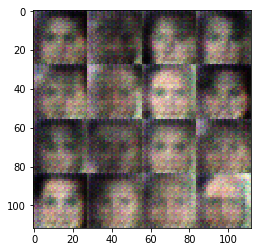

Epoch 1/1... Discriminator Loss: 0.4805... Generator Loss: 2.6205
Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 2.5924
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 8.8922
Epoch 1/1... Discriminator Loss: 2.7514... Generator Loss: 0.1094
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.4559
Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 4.7587
Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 5.8814
Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 4.4112
Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 1.8264
Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 6.7130


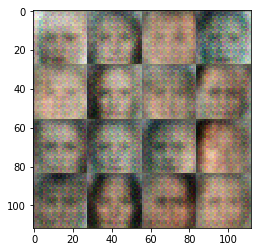

Epoch 1/1... Discriminator Loss: 0.3789... Generator Loss: 3.4830
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 3.8631
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 4.3156
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 1.8610
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 3.3930
Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 5.2827
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 2.1853
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 1.7827
Epoch 1/1... Discriminator Loss: 0.4482... Generator Loss: 3.6640


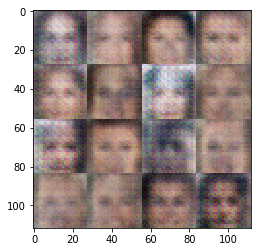

Epoch 1/1... Discriminator Loss: 0.3662... Generator Loss: 4.4428
Epoch 1/1... Discriminator Loss: 0.5534... Generator Loss: 1.9070
Epoch 1/1... Discriminator Loss: 0.3721... Generator Loss: 4.9014
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 2.8786
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 0.3961... Generator Loss: 5.3563
Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 7.6626
Epoch 1/1... Discriminator Loss: 0.3767... Generator Loss: 3.6987
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 7.6343
Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 6.9377


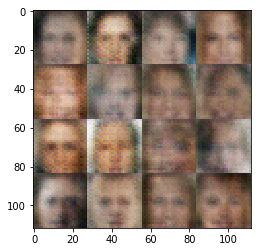

Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 2.5570
Epoch 1/1... Discriminator Loss: 0.3617... Generator Loss: 4.0908
Epoch 1/1... Discriminator Loss: 0.3385... Generator Loss: 9.8188
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 10.7286
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 5.7136
Epoch 1/1... Discriminator Loss: 0.3361... Generator Loss: 7.8614
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 2.4310
Epoch 1/1... Discriminator Loss: 0.3444... Generator Loss: 5.2104
Epoch 1/1... Discriminator Loss: 1.8314... Generator Loss: 0.3261
Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 3.8208


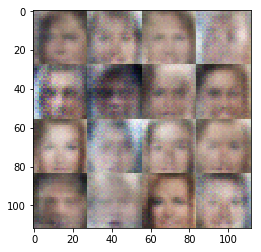

Epoch 1/1... Discriminator Loss: 0.4264... Generator Loss: 7.2208
Epoch 1/1... Discriminator Loss: 0.3472... Generator Loss: 6.3433
Epoch 1/1... Discriminator Loss: 0.3417... Generator Loss: 6.6793
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 5.9205
Epoch 1/1... Discriminator Loss: 0.3400... Generator Loss: 6.9225
Epoch 1/1... Discriminator Loss: 0.3375... Generator Loss: 7.1483
Epoch 1/1... Discriminator Loss: 0.4310... Generator Loss: 2.6601
Epoch 1/1... Discriminator Loss: 0.4213... Generator Loss: 2.8252
Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 1.5138
Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 2.0986


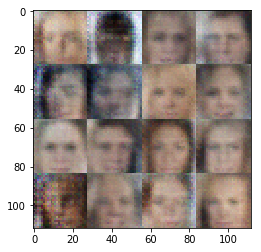

Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 4.9311
Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 3.0128
Epoch 1/1... Discriminator Loss: 0.3357... Generator Loss: 8.3814
Epoch 1/1... Discriminator Loss: 0.3384... Generator Loss: 6.6463
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.6735
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 6.6467
Epoch 1/1... Discriminator Loss: 0.3682... Generator Loss: 5.2366
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 0.3487... Generator Loss: 4.7939


In [14]:
batch_size = 256
z_dim = 512
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.